In [1]:
import os

os.chdir(globals()["_dh"][0])
print("Current working directory:", os.getcwd())
os.chdir('/home/mohammad.hallaq/workarea/MobileNet_compression') # change accordingly

Current working directory: /home/mohammad.hallaq/workarea/MobileNet_compression


In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch_pruning as tp
from mobilenetv3 import mobilenetv3
from collections import defaultdict
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as L
import h5py
from torch.utils.data import Dataset
import copy
import torch.nn as nn 
from tqdm import tqdm
from torchinfo import summary
import csv
from torch.profiler import profile
import math 

In [3]:
general_device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

In [4]:
# Free up cached memory
torch.cuda.empty_cache()

# Clear all the gradients
torch.cuda.reset_max_memory_allocated()

/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/cuda/memory.py:330: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [5]:
class RFClassifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.lr = 5e-4
        self.lr_ignored = 5e-4  # Learning rate for ignored layers

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        # Initialize lists for different parameter groups
        ignored_layers_params = []
        other_layers_params = []

        # Collect parameters of specific layers based on layer names and conditions
        ignored_params_set = set()
        for name, m in self.model.named_modules():
            if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
                ignored_layers_params += list(m.parameters())
                ignored_params_set.update(m.parameters())  # Add to set to avoid duplicates

        # Other parameters: Exclude the ignored layers' parameters
        other_layers_params = [p for p in self.model.parameters() if p not in ignored_params_set]

        # Create the optimizer with different learning rates for different parameter groups
        optimizer = torch.optim.AdamW([
            {'params': ignored_layers_params, 'lr': self.lr_ignored},  # Lower learning rate for ignored layers
            {'params': other_layers_params, 'lr': self.lr}  # Default learning rate for other layers
        ], weight_decay=0)

        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)

        return {'optimizer': optimizer, 'lr_scheduler': {'scheduler': lr_scheduler, 'interval': 'step'}}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)

In [6]:
class CustomCheckpoint(L.Callback):
    def __init__(self):
        super().__init__()
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_validation_end(self, trainer, pl_module):
        # Access validation loss from the trainer's metrics
        val_loss = trainer.callback_metrics.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = pl_module.model
            # Save the best model
            torch.save(self.best_model, 'pruning_results/best_model.pth')
            print(f"New best model saved with validation loss {val_loss:.4f}")


In [7]:
class R22_H5_Dataset(Dataset):
    def __init__(self, data_file, label='label', iqlabel='iq_data'):
        self.data_file = data_file
        self.label = label
        self.iqlabel = iqlabel

    def __len__(self):
        with h5py.File(self.data_file, 'r') as f:
            length = len(f[self.label])
        return length

    def __getitem__(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            iq_data = f[self.iqlabel][idx]
            label = f[self.label][idx]
        return iq_data, label
    
    def get_metadata(self, idx):
        with h5py.File(self.data_file, 'r') as f:
            metadata = {
                'recording': f['recording'][idx].decode('utf-8)'),
                'category': f['category'][idx].decode('utf-8)')
            }
        return metadata


In [24]:
# def prune_model(trained_model, prune_method, prune_amount, train_loader):

#     # torch.manual_seed(80) 
#     model =  copy.deepcopy(trained_model)
#     device = general_device
#     model.to(device)

#     example_length = 4096

#     if prune_method == 'channel_pruning_Taylor_importance':
#         imp = tp.importance.TaylorImportance() 

#         ignored_layers_group1 = []

#         for name, m in model.named_modules():
#             # Check if the module is within Sequential(3), Sequential(4), Sequential(5) or the classifier
#             if any(name.startswith(f'blocks.{i}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
#                 ignored_layers_group1.append(m)

#         ignored_layers_group2 = []
    
#         for name, m in model.named_modules():
#             # Check if the module is within Sequential(0), Sequential(1), Sequential(2) or the classifier
#             if any(name.startswith(f'blocks.{i+3}') for i in range(3)) or (isinstance(m, torch.nn.Linear) and m.out_features == 2):
#                 ignored_layers_group2.append(m) 

#         batch = next(iter(train_loader))
#         x, y = batch
#         x = x.to(device)
       
#         iterative_steps = 1
#         pruner_group1 = tp.pruner.MagnitudePruner( 
#             model,
#             example_inputs=x,
#             importance=imp,
#             pruning_ratio=prune_amount, 
#             ignored_layers=ignored_layers_group1,
#             iterative_steps= iterative_steps,
#         )

#         pruner_group2 = tp.pruner.MagnitudePruner( 
#             model,
#             example_inputs=x,
#             importance=imp,
#             pruning_ratio=0.5, 
#             ignored_layers=ignored_layers_group2,
#             iterative_steps= iterative_steps,
#         )

#         # prune the model, iteratively if necessary.
#         for i in range(iterative_steps):
#             if isinstance(imp, tp.importance.TaylorImportance):
#                 x, y = batch
#                 x = x.to(device)
#                 y = y.to(device)
#                 y_hat = model(x)
#                 loss = F.mse_loss(y_hat, y)
#                 loss.backward()

#             pruner_group1.step()
#             pruner_group2.step()

#     # Free up GPU memory
#     del x, y, batch  # Remove any tensors on the GPU

#     torch.cuda.empty_cache()  # Clear the cache

#     return model

In [7]:
# original_model_checkpoint = 'august22_beam_t.ckpt'
original_model_checkpoint = 'checkpoint_sep_data_model_state'

In [8]:
# train_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_train_P100_N10.h5'
# # val_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'
# test_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'
# checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints'
# checkpoint_filename = os.path.join(checkpoint_dir, 'r22_sept15.ckpt')
# checkpoint =torch.load(checkpoint_filename)
# # checkpoint_dir = '/home/mohammad.hallaq/workarea/MobileNet_compression/sep_dataset_checkpoint'
# # checkpoint_filename = os.path.join(checkpoint_dir, 'checkpoint_sep_data_model_state.ckpt')
# # checkpoint =torch.load(checkpoint_filename)

In [8]:
example_length = 4096
batch_size = 256
epochs =30

hparams = {
    'drop_path_rate': 0.2,
    'drop_rate': 0.7,
    'learning_rate': 1e-3,
    'wd': 0.01
}

In [10]:
# def train_model_with_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, prune_amount):
#     checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
#     final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

   
#     if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
#         print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
#         return

#     pruned_model = prune_model(trained_model, pruning_method, prune_amount, train_loader)

#     rf_classifier = RFClassifier(pruned_model)

#     checkpoint_callback = L.callbacks.ModelCheckpoint(
#         dirpath='.',
#         filename=checkpoint_filename.replace(".ckpt", ""),
#         save_top_k=1,
#         verbose=True,
#         monitor='val_loss',
#         mode='min'
#     )
    
#     # Create the custom callback
#     custom_checkpoint = CustomCheckpoint()

#     trainer = L.Trainer(
#         max_epochs=30,
#         callbacks=[checkpoint_callback, custom_checkpoint],
#         accelerator='gpu',
#         devices=[3],
#         benchmark=True,
#         precision='32-true',
#     )

#     print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
#     trainer.fit(rf_classifier, train_loader, val_loader)

#     torch.save(rf_classifier.model, final_model_path)

#     print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved. ")


In [10]:
# train_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_train.h5'
# val_data = '/home/mohammad.hallaq/workarea/AoA-Pruning/data_h5py_files/r22_test.h5'

In [9]:
# example_length = 4096
# batch_size = 128
# epochs =30

In [9]:
# train_data = '/shared/sepData_train.h5'
# val_data = '/shared/sepData_val.h5'
# test_data = '/shared/sepData_test.h5'
train_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_train_P100_N10.h5'
# val_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'
test_data = '/home/mohammad.hallaq/workarea/MobileNet_compression/data_h5py_files/sepData_test_P100_N10.h5'

train_set = R22_H5_Dataset(train_data)
# val_set = R22_H5_Dataset(val_data)
test_set = R22_H5_Dataset(test_data)
print(f'Training Set: {len(train_set)} examples')
# print(f'Validation Set: {len(val_set)} examples')
print(f'Testing Set: {len(test_set)} examples')

num_classes = train_set[0][1].shape[0]

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,
    )
# val_loader = torch.utils.data.DataLoader(
#     dataset=val_set,
#     batch_size=128,
#     shuffle=False,
#     num_workers=8
#     )
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=128,
    shuffle=False,
    num_workers=8
    )

Training Set: 98120 examples
Testing Set: 45980 examples


In [10]:
original_model = mobilenetv3(
    model_size='mobilenetv3_small_050',
    num_classes=num_classes,
    drop_rate=hparams['drop_rate'],
    drop_path_rate=hparams['drop_path_rate'],
    in_chans=8
)

# rf_classifier = RFClassifier.load_from_checkpoint(original_model_checkpoint, model=model)

# rf_classifier.to('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
def remove_prefix_from_state_dict(state_dict, prefix='model.'):

    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith(prefix):
            new_state_dict[k[len(prefix):]] = v
        else:
            new_state_dict[k] = v
    return new_state_dict

In [ ]:
checkpoint['state_dict'] = remove_prefix_from_state_dict(checkpoint['state_dict'], prefix='model.')

original_model.load_state_dict(checkpoint['state_dict'])
# checkpoint = remove_prefix_from_state_dict(checkpoint, prefix='model.')

# original_model.load_state_dict(checkpoint)

In [12]:
#Elsayed pre-trained model

original_model = original_model.to(general_device)
checkpoint = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/checkpoints/8oct_mobilenet_sepdata_P20Nmax_noTransform_80epochs_checkpoint_model_state_best.pth', map_location=general_device)
original_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [13]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_amounts = [0.95]  

In [16]:
pruned_model = prune_model(original_model, pruning_methods[0], pruning_amounts[0], train_loader)
# Free up cached memory
torch.cuda.empty_cache()
example_inputs = torch.randn(1, 8, 4096)
example_inputs = example_inputs.to(general_device)  
macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

[Sequential(
  (0): InvertedResidual(
    (conv_pw): Conv1d(7, 40, kernel_size=(1,), stride=(1,))
    (bn1): GBN(
      (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (conv_dw): Conv1d(40, 40, kernel_size=(3,), stride=(2,), padding=(1,), groups=40)
    (bn2): GBN(
      (bn): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
    (aa): Identity()
    (se): Identity()
    (conv_pwl): Conv1d(40, 16, kernel_size=(1,), stride=(1,))
    (bn3): GBN(
      (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Identity()
      (act): Identity()
    )
    (drop_path): DropPath(drop_prob=0.017)
  )
  (1): InvertedResidual(
    (conv_pw): Conv1d(16, 56, kernel_size=(1,), stride=(1,))
    (bn1): GBN(
      (bn): BatchNorm1d(56, eps=1e-05, momentum=0.1, affin

In [ ]:
for method in pruning_methods:
    for amount in pruning_amounts:
        train_model_with_pruning(original_model, method, method, train_loader, val_loader, amount)


Evaluating The Pruned Model

In [22]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/best_model.pth')
# example_inputs = torch.randn(1, 8, 4096)
# example_inputs = example_inputs.to(general_device)  
# macs, nparams = tp.utils.count_ops_and_params(pruned_model, example_inputs)
# print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

In [23]:
rf_classifier = RFClassifier(pruned_model)

trainer = L.Trainer(
    max_epochs=1,
    accelerator='gpu',
    devices=[3],
    benchmark=True,
    precision='32-true',
)

trainer.test(rf_classifier, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    17.421855926513672     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 17.421855926513672}]

In [14]:
def plot_quiver(all_targets, all_outputs, quiver_path: str):
    """
    Creates and stores the quiver plot for given targets and predicted outputs
    :args all_targets:
    :args all_outputs:
    """
    predictions_per_target = defaultdict(list)
    errors_per_target = dict()

    for idx, target_angles_tuple in enumerate(all_targets):
        target_tuple = tuple(target_angles_tuple)
        predictions_per_target[target_tuple].append(all_outputs[idx])
    for target_tuple, list_of_predictions in predictions_per_target.items():
        # predictions_per_target[target_tuple] = np.mean(list_of_predictions, axis=0)
        errors_per_target[target_tuple] = np.subtract(target_tuple, np.mean(list_of_predictions, axis=0))

    unique_targets = list(errors_per_target.keys())
    unique_azimuth = [target[0] for target in unique_targets]
    unique_elevation = [target[1] for target in unique_targets]
    unique_erros = list(errors_per_target.values())
    errors_azimuth = [target[0] for target in unique_erros]
    errors_elevation = [target[1] for target in unique_erros]

    plt.figure(figsize=(10, 10))
    plt.scatter(unique_azimuth, unique_elevation, color='red', label='True Angles')
    plt.quiver(unique_azimuth, unique_elevation, errors_azimuth, errors_elevation,
                angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')
    plt.xlim([-55, 55])
    plt.ylim([-55, 55])
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.grid()
    plt.legend()
    plt.savefig(quiver_path)

Training: 100%|██████████| 384/384 [00:19<00:00, 19.97batch/s]


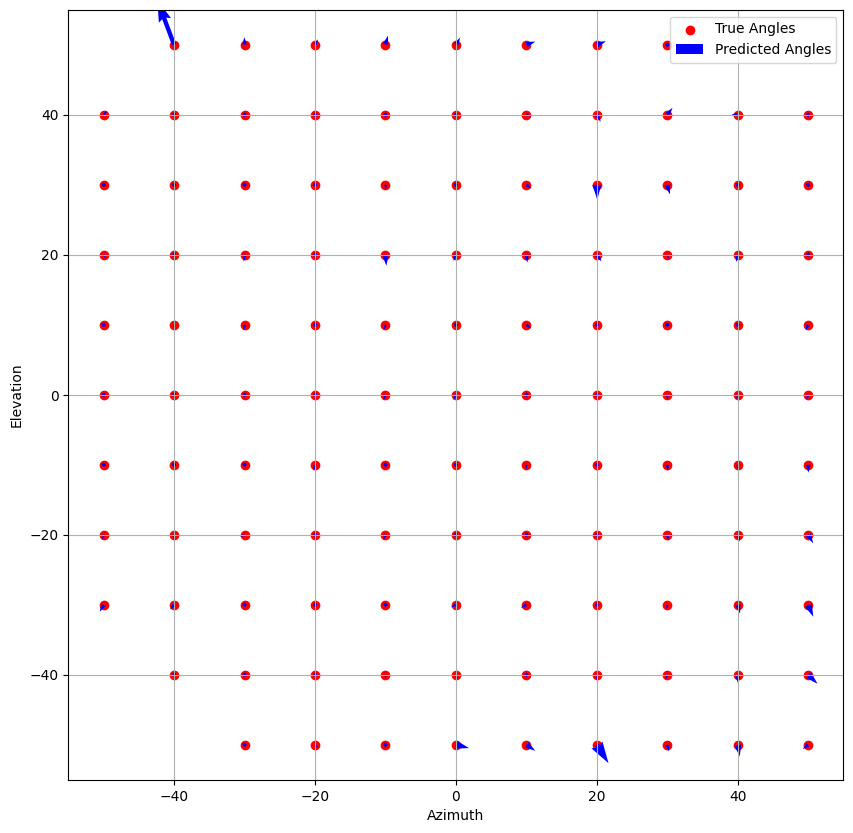

In [15]:
original_model.eval()
test_loss = 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
device = general_device
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
original_model.to(device)

with torch.no_grad():
    with tqdm(train_loader, desc='Training', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = original_model(sample_inputs)
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))           
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    quiver_path = os.path.join(experiment_path, "training_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)

Testing: 100%|██████████| 360/360 [00:12<00:00, 28.59batch/s, Val Loss=0.604]


Test Set Loss = 0.0016785163691210333


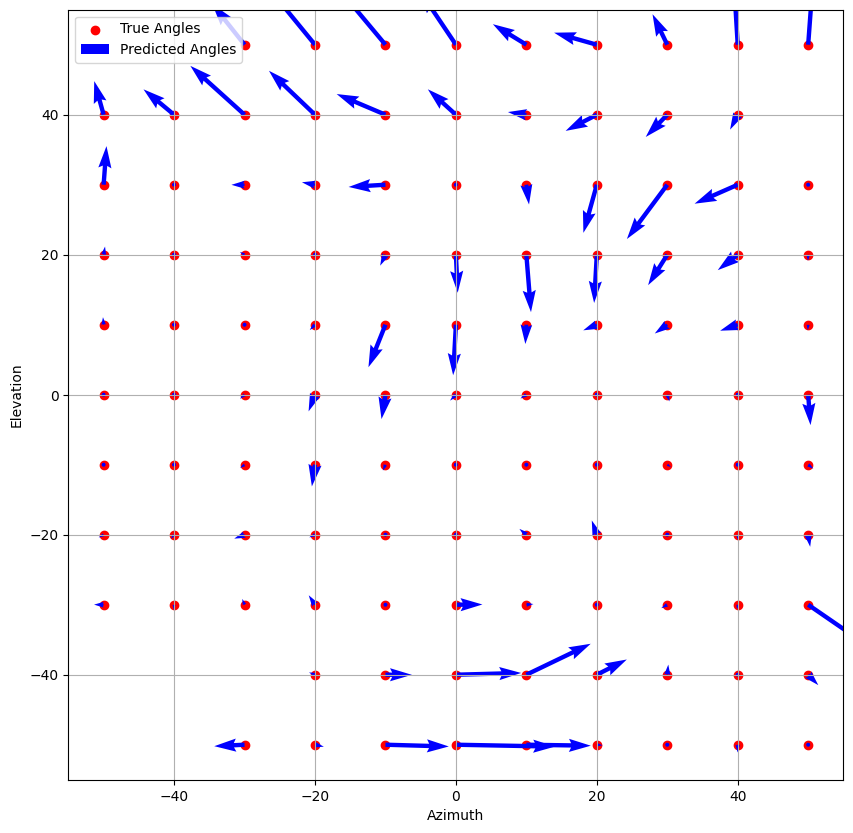

In [22]:
criterion = nn.MSELoss()
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
device = general_device
original_model = original_model.to(device)
original_model.eval()
eval_values = {'azimuth_true': [], 'azimuth_pred': [], 'elevation_true': [], 'elevation_pred': [], 'loss_value': []}

test_loss, num_samples = 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = original_model(sample_inputs)
            loss = criterion(outputs, targets)
            eval_values['azimuth_pred'] = targets
            num_samples += targets.shape[0]
            test_loss += loss.item()/num_samples
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))
            pbar.set_postfix({'Val Loss': test_loss})
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_loss = test_loss / len(test_loader)
    print(f"Test Set Loss = {test_loss}")
    quiver_path = os.path.join(experiment_path, "testing_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)

In [24]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# Define both MSE and MAE criteria
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

device = general_device
pruned_model = pruned_model.to(device)
pruned_model.eval()

# Initialize dictionaries to accumulate MSE and MAE losses for each angle
angle_loss_accumulation = {
    'azimuth_mse': {angle: 0.0 for angle in range(-50, 60, 10)},
    'elevation_mse': {angle: 0.0 for angle in range(-50, 60, 10)},
    'azimuth_mae': {angle: 0.0 for angle in range(-50, 60, 10)},
    'elevation_mae': {angle: 0.0 for angle in range(-50, 60, 10)},
    'azimuth_count': {angle: 0 for angle in range(-50, 60, 10)},
    'elevation_count': {angle: 0 for angle in range(-50, 60, 10)}
}

test_mse, test_mae, num_samples = 0, 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])

with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = pruned_model(sample_inputs)
            
            # Calculate losses for this batch
            mse_loss = mse_criterion(outputs, targets)
            mae_loss = mae_criterion(outputs, targets)
            num_samples += targets.shape[0]

            test_mse += mse_loss.item() / num_samples
            test_mae += mae_loss.item() / num_samples

            # Convert to CPU and detach for evaluation
            outputs_np = outputs.cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Accumulate MSE and MAE losses for each angle
            for i in range(targets_np.shape[0]):
                true_azimuth, true_elevation = targets_np[i]
                pred_azimuth, pred_elevation = outputs_np[i]

                azimuth_mse = (pred_azimuth - true_azimuth) ** 2
                elevation_mse = (pred_elevation - true_elevation) ** 2

                azimuth_mae = abs(pred_azimuth - true_azimuth)
                elevation_mae = abs(pred_elevation - true_elevation)

                # Accumulate losses for each azimuth and elevation value
                angle_loss_accumulation['azimuth_mse'][int(true_azimuth)] += azimuth_mse
                angle_loss_accumulation['elevation_mse'][int(true_elevation)] += elevation_mse
                angle_loss_accumulation['azimuth_mae'][int(true_azimuth)] += azimuth_mae
                angle_loss_accumulation['elevation_mae'][int(true_elevation)] += elevation_mae

                # Count occurrences of each azimuth and elevation value
                angle_loss_accumulation['azimuth_count'][int(true_azimuth)] += 1
                angle_loss_accumulation['elevation_count'][int(true_elevation)] += 1

            all_targets = np.concatenate((all_targets, targets_np))
            all_outputs = np.concatenate((all_outputs, outputs_np))

            pbar.set_postfix({'Val MSE Loss': test_mse, 'Val MAE Loss': test_mae})

    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_mse = test_mse / len(test_loader)
    test_mae = test_mae / len(test_loader)

    # Calculate average MSE and MAE loss per angle
    avg_azimuth_mse, avg_elevation_mse = {}, {}
    avg_azimuth_mae, avg_elevation_mae = {}, {}

    for angle in range(-50, 60, 10):
        if angle_loss_accumulation['azimuth_count'][angle] > 0:
            avg_azimuth_mse[angle] = angle_loss_accumulation['azimuth_mse'][angle] / angle_loss_accumulation['azimuth_count'][angle]
            avg_azimuth_mae[angle] = angle_loss_accumulation['azimuth_mae'][angle] / angle_loss_accumulation['azimuth_count'][angle]
        else:
            avg_azimuth_mse[angle] = 0.0
            avg_azimuth_mae[angle] = 0.0

        if angle_loss_accumulation['elevation_count'][angle] > 0:
            avg_elevation_mse[angle] = angle_loss_accumulation['elevation_mse'][angle] / angle_loss_accumulation['elevation_count'][angle]
            avg_elevation_mae[angle] = angle_loss_accumulation['elevation_mae'][angle] / angle_loss_accumulation['elevation_count'][angle]
        else:
            avg_elevation_mse[angle] = 0.0
            avg_elevation_mae[angle] = 0.0

    print(f"Test Set MSE Loss = {test_mse}")
    print(f"Test Set MAE Loss = {test_mae}")
    print(f"Azimuth MSE Loss by Angle: {avg_azimuth_mse}")
    print(f"Elevation MSE Loss by Angle: {avg_elevation_mse}")
    print(f"Azimuth MAE Loss by Angle: {avg_azimuth_mae}")
    print(f"Elevation MAE Loss by Angle: {avg_elevation_mae}")


Testing: 100%|██████████| 360/360 [00:08<00:00, 44.10batch/s, Val MSE Loss=0.819, Val MAE Loss=0.157]

Test Set MSE Loss = 0.002274470876823534
Test Set MAE Loss = 0.0004351161149464336
Azimuth MSE Loss by Angle: {-50: 9.322987003475694, -40: 10.776542919187596, -30: 18.10026383387895, -20: 16.549456863433246, -10: 21.514832795244196, 0: 24.590908095654108, 10: 30.98614140927396, 20: 22.04925998076995, 30: 20.074403589034393, 40: 22.30198700478166, 50: 16.003716161277318}
Elevation MSE Loss by Angle: {-50: 35.8180826386433, -40: 22.175420807542015, -30: 11.741761853081524, -20: 11.329170238164249, -10: 19.350799122395102, 0: 15.990523159724658, 10: 17.04793549554149, 20: 21.52940815298188, 30: 21.655838746416364, 40: 25.442287274968784, 50: 66.68810925520035}
Azimuth MAE Loss by Angle: {-50: 2.233998483137651, -40: 2.6764619728826706, -30: 3.1563948870334273, -20: 3.0150144710097204, -10: 3.559504486188828, 0: 3.937448875905343, 10: 4.269344477220015, 20: 3.8278021916811045, 30: 3.6294917214471853, 40: 3.962026115834288, 50: 3.006088425853465}
Elevation MAE Loss by Angle: {-50: 5.026691

In [25]:
def calculate_average_deviation(loader, model):
    device = next(model.parameters()).device
    model.to(device)
    total_azimuth_deviation = 0
    total_elevation_deviation = 0
    num_samples = 0
    with torch.no_grad():
        for batch in loader:
            inputs, true_angles = batch
            inputs, true_angles = inputs.to(device), true_angles.to(device)
            predicted = model(inputs).cpu().numpy()
            true_angles = true_angles.cpu().numpy()
            azimuth_deviation = np.abs(predicted[:, 0] - true_angles[:, 0])
            elevation_deviation = np.abs(predicted[:, 1] - true_angles[:, 1])
        
            total_azimuth_deviation += np.sum(azimuth_deviation)
            total_elevation_deviation += np.sum(elevation_deviation)
            num_samples += len(true_angles)
    avg_azimuth_deviation = total_azimuth_deviation / num_samples
    avg_elevation_deviation = total_elevation_deviation / num_samples
    return avg_azimuth_deviation, avg_elevation_deviation

In [31]:
avg_azim_dev, avg_elev_dev = calculate_average_deviation(val_loader, pruned_model)
print(avg_azim_dev, avg_elev_dev)

2.4380250465029167 2.6354439758350545


In [13]:
original_model

MobileNetV3(
  (conv_stem): Conv1d(8, 16, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): GBN(
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv1d(16, 16, kernel_size=(3,), stride=(2,), padding=(1,), groups=16)
        (bn1): GBN(
          (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv1d(16, 8, kernel_size=(1,), stride=(1,))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
        )
        (conv_pw): Conv1d(16, 8, kernel_size=(1,), stride=(1,))
        (bn2): GBN(
          (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, trac

In [13]:
class ActivationAggregator:
    def __init__(self):
        self.activations = {}
        self.aggregated_activations = {}

    def hook(self, module, input, output, layer_name, block_name):
        # Capture individual activations
        if layer_name not in self.activations:
            self.activations[layer_name] = output.detach().clone()
        else:
            self.activations[layer_name] += output.detach().clone()
        
        # Aggregate activations for the block
        if block_name not in self.aggregated_activations:
            self.aggregated_activations[block_name] = output.detach().clone()
        else:
            self.aggregated_activations[block_name] += output.detach().clone()

    def attach_hooks(self, model):
        block_idx = 0
        for block in model.blocks:
            for i, layer in enumerate(block):
                if isinstance(layer, nn.Sequential):
                    for j, sub_layer in enumerate(layer):
                        layer_name = f"block_{block_idx}_layer_{i}_sub_layer_{j}"
                        block_name = f"block_{block_idx}"
                        sub_layer.register_forward_hook(
                            lambda mod, inp, out, name=layer_name, block=block_name: self.hook(mod, inp, out, name, block)
                        )
                else:
                    layer_name = f"block_{block_idx}_layer_{i}"
                    block_name = f"block_{block_idx}"
                    layer.register_forward_hook(
                        lambda mod, inp, out, name=layer_name, block=block_name: self.hook(mod, inp, out, name, block)
                    )
            block_idx += 1

    def clear_activations(self):
        # Clear individual activations and aggregated activations after each forward pass
        self.activations = {}
        self.aggregated_activations = {}




model = original_model  
aggregator = ActivationAggregator()

# Attach hooks to the model
aggregator.attach_hooks(model)

scores = {}  # To store the aggregated scores for each block across batches

# Initialize the scores dictionary with 0 for each block
for block_name in [f"block_{i}" for i in range(len(model.blocks))]:
    scores[block_name] = 0.0

# Loop through the test data loader
for i, (input, target) in enumerate(test_loader):
    input = input.to(general_device)
    
    # Forward pass through the model
    model(input)

    # Aggregate activations per block for the current batch
    for block_name, activation in aggregator.aggregated_activations.items():
        # Perform the aggregation (sum and mean) for each block
        aggregated_value = torch.mean(torch.sum(torch.sum(activation, dim=0), dim=1))
        
        # Accumulate scores across batches
        scores[block_name] += aggregated_value.item()

    # Clear activations for the next batch
    aggregator.clear_activations()

# Print the final accumulated scores for each block
for block_name, score in scores.items():
    print(f"{block_name}: {score}")
    
# # Forward pass (with a dummy input of shape [batch_size, 8, 4096])
# x,_ = next(iter(train_loader))
# # x = x[0].unsqueeze(0)
# x = x.to(general_device)

# model(x)

# # Access individual layer activations
# print("Individual Layer Activations:")
# for layer_name, activation in aggregator.activations.items():
#     print(f"{layer_name}: {torch.mean(activation)}")

# # Access aggregated activations for each block
# print("\nAggregated Activations per Block:")
# for block_name, activation in aggregator.aggregated_activations.items():
#     print(f"{block_name}: {torch.mean(torch.sum(torch.sum(activation, dim=0), dim=1))}")

# # Clear activations if needed for the next forward pass
# aggregator.clear_activations()


block_0: 5683433.966796875
block_1: 688666.7939453125
block_2: 1251886.1856689453
block_3: 1059496.609008789
block_4: -1107828.1356811523
block_5: 16291.169533729553


In [14]:
for block_name, score in scores.items():
    print(f"{block_name}: {score/1e6}")
    

block_0: 5.683433966796875
block_1: 0.6886667939453125
block_2: 1.2518861856689454
block_3: 1.0594966090087892
block_4: -1.1078281356811523
block_5: 0.016291169533729555


In [13]:
def get_first_layer_output_channels(model):
    output_channels = []

    for _, module in model.named_modules():
        if isinstance(module, nn.Sequential):
            for _, sub_module in module.named_children():
                for _, layer in sub_module.named_children():
                    if isinstance(layer, nn.Conv1d):
                        output_channels.append(layer.out_channels)
                        break  # Exit after the first Conv1d layer
                break  # Exit after inspecting the first block in Sequential

    return output_channels

# Assuming `mobilenet_v3` is your model instance
output_channels = get_first_layer_output_channels(original_model)
print(output_channels)


[16, 40, 64, 72, 144, 288]


In [14]:
model =  copy.deepcopy(original_model)
device = 'cpu'
model.to(device)

batch = next(iter(train_loader))
x, y = batch
x,y = x.to(device), y.to(device)
imp = tp.importance.TaylorImportance()

output_channels = get_first_layer_output_channels(model)


pruning_ratios = [0.93, 0.0, 0.0, 0.0, 0.0, 0.0]

pruning_info = {
    i: {"block": model.blocks[i], "pruning_ratio": ratio}
    for i, ratio in enumerate(pruning_ratios)
}

if isinstance(imp, tp.importance.TaylorImportance):
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y)
    loss.backward()

# First, collect the layers to be ignored (conv_stem, bn1, and classifier)
ignored_layers = [
    # model.conv_stem, 
    # model.bn1,
    model.global_pool,
    model.conv_head,
    model.norm_head,
    model.act2,
    model.flatten,
    model.classifier
]

# ignored_layers_group = []
# Iterate through the named modules of the model to add layers to be ignored
# for name, m in original_model.named_modules():
#     # Add layers from Sequential(3), Sequential(4), Sequential(5) and the classifier
#     if (isinstance(m, torch.nn.Linear) and m.out_features == 2):
#         ignored_layers_group.append(m)

# Example usage for pruning while ignoring other blocks
for i, info in pruning_info.items():
    block_to_prune = info["block"]
    pruning_ratio = info["pruning_ratio"]
    
    # # Now add all other blocks to ignored layers except the current block to be pruned
    # for j, block in enumerate(model.blocks):
    #     if block != block_to_prune:
    #         ignored_layers_group.append(block)

    # Dynamically ignore other blocks except the current block to prune
    ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

    # Combine ignored layers (including initial layers, classifier, and other blocks)
    combined_ignored_layers = []
    combined_ignored_layers = ignored_layers + ignored_layers_block
    # print(block_to_prune)
    if pruning_ratio == 0.99: 
        print("The ignored blocks are:", combined_ignored_layers)
        print("The pruned block is:", block_to_prune)
        
    print('Pruning ratio here is: ', pruning_ratio)
    
    # Apply pruning
    pruner_group =  tp.pruner.MagnitudePruner( 
        model,
        example_inputs=x,
        importance=imp,
        pruning_ratio=pruning_ratio,
        ignored_layers=combined_ignored_layers,
    )

    pruner_group.step()

    # if i < 2:
    #     print(model)

    example_inputs = torch.randn(1, 8, 4096).to(device)
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")

Pruning ratio here is:  0.93
MACs: 0.022379553 G, #Params: 547.612 K
Pruning ratio here is:  0.0
MACs: 0.022379553 G, #Params: 547.612 K
Pruning ratio here is:  0.0
MACs: 0.022379553 G, #Params: 547.612 K
Pruning ratio here is:  0.0
MACs: 0.022379553 G, #Params: 547.612 K
Pruning ratio here is:  0.0
MACs: 0.022379553 G, #Params: 547.612 K
Pruning ratio here is:  0.0
MACs: 0.022379553 G, #Params: 547.612 K


In [15]:
def prune_model(trained_model, prune_method, pruning_ratios, train_loader):
    # Make a copy of the trained model
    model = copy.deepcopy(trained_model)
    device = 'cpu'  # Assuming general_device is defined elsewhere
    model.to(device)

    pruning_info = {
    i: {"block": model.blocks[i], "pruning_ratio": ratio}
    for i, ratio in enumerate(pruning_ratios)
}

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 

        # Prepare a batch from the train loader for pruning and backward pass
        batch = next(iter(train_loader))
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Perform forward and backward passes to calculate importance scores if using TaylorImportance
        if isinstance(imp, tp.importance.TaylorImportance):
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)
            loss.backward()

        # Define layers to always ignore (conv_stem, bn1, and classifier)
        ignored_layers = [
            # model.conv_stem, 
            # model.bn1,
            model.global_pool,
            model.conv_head,
            model.norm_head,
            model.act2,
            model.flatten,
            model.classifier
        ]

        # Assuming `pruning_info` is a dictionary with blocks and pruning ratios
        # Example of how `pruning_info` can be structured:
        # pruning_info = {i: {"block": model.blocks[i], "pruning_ratio": ratio} for i, ratio in enumerate(prune_ratios)}

        # Prune each block while ignoring other layers
        for i, info in pruning_info.items():
            block_to_prune = info["block"]
            pruning_ratio = info["pruning_ratio"]
            
            # Add all blocks to the ignored layers except the block being pruned
            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

            # Combine fixed ignored layers (conv_stem, bn1, classifier) with the ignored blocks
            combined_ignored_layers = ignored_layers + ignored_layers_block

            if pruning_ratio == 0.99: 
                print("The ignored blocks are:", combined_ignored_layers)
                print("The pruned block is:", block_to_prune)

            # Apply pruning using the combined ignored layers
            pruner_group = tp.pruner.MagnitudePruner( 
                model,
                example_inputs=x,
                importance=imp,
                pruning_ratio=pruning_ratio,
                ignored_layers=combined_ignored_layers,
                iterative_steps=1,
            )

            # Step through pruning
            pruner_group.step()

    # Counting MACs and Params after pruning
    example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

    # Free up GPU memory
    del x, y, batch
    torch.cuda.empty_cache()

    return model


In [16]:
# Function to perform perplexity analysis, return average loss, and calculate relative contribution percentages
def perplexity_analysis_with_contributions(original_model, data_loader, criterion, num_iterations=5):
    total_block_losses = [0.0 for _ in range(len(original_model.blocks))]

    # Step 1: Compute the baseline loss (without block replacement)
    print("Computing baseline loss without block replacement...")
    baseline_loss = compute_baseline_loss(original_model, data_loader, criterion)
    print(f"Baseline Loss: {baseline_loss}")
    
    # Outer loop to run the analysis multiple times for averaging
    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1}/{num_iterations}")

        # Iterate through each block for replacement
        for block_idx in range(len(original_model.blocks)):

            output_channels = get_first_layer_output_channels(original_model)

            print(f"Replacing block {block_idx}")
            pruning_ratios = (np.eye(len(original_model.blocks)) * math.floor(1000 - (1000/output_channels[block_idx]))/1000)[block_idx]
            
            pruned_model = prune_model(original_model,'channel_pruning_Taylor_importance', pruning_ratios, data_loader)

            # # Replace one block at a time with a linear layer
            # modified_model = ModifiedMobileNetV3(original_model, block_to_replace=block_idx)
            print(pruned_model)
            pruned_model.to(general_device)

            # Run validation and compute loss
            pruned_model.eval()
            total_loss = 0.0
            with torch.no_grad():
                for inputs, targets in data_loader:
                    inputs, targets = inputs.to(general_device), targets.to(general_device)
                    outputs = pruned_model(inputs)
                    loss = criterion(outputs, targets)
                    total_loss += loss.item()

            # Calculate average loss for the current block
            average_loss = total_loss / len(data_loader)
            print(f'Loss for block {block_idx} in iteration {iteration + 1}: {average_loss}')
            
            # Accumulate the loss for each block
            total_block_losses[block_idx] += average_loss

    # Step 2: Calculate the final averaged loss and contribution for each block across iterations
    total_increase_in_loss = 0.0
    block_increases = []
    
    for block_idx in range(len(original_model.blocks)):
        final_average_loss = total_block_losses[block_idx] / num_iterations
        increase_in_loss = final_average_loss - baseline_loss
        block_increases.append(increase_in_loss)
        total_increase_in_loss += increase_in_loss  # Accumulate total increase in loss
    
    # Step 3: Calculate the relative contribution of each block to the total increase in loss
    relative_contributions = []
    print("\nRelative contribution of each block to total loss increase:")
    for block_idx in range(len(original_model.blocks)):
        relative_contribution = (block_increases[block_idx] / total_increase_in_loss) * 100
        print(f'Block {block_idx} contributes {relative_contribution:.2f}% to the total increase in loss')
        relative_contributions.append(relative_contribution)

    return relative_contributions

# Helper function to compute the baseline loss (without replacing any block)
def compute_baseline_loss(original_model, data_loader, criterion):
    original_model.to(general_device)
    original_model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(general_device), targets.to(general_device)
            outputs = original_model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    baseline_loss = total_loss / len(data_loader)
    return baseline_loss



In [17]:
relative_contribution = perplexity_analysis_with_contributions(original_model, test_loader, criterion = nn.MSELoss(), num_iterations=1)

Computing baseline loss without block replacement...
Baseline Loss: 16.092444930308396
Iteration 1/1
Replacing block 0
MACs: 0.022379553 G, #Params: 547.612 K
MobileNetV3(
  (conv_stem): Conv1d(8, 1, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): GBN(
    (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv1d(1, 1, kernel_size=(3,), stride=(2,), padding=(1,))
        (bn1): GBN(
          (bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv1d(1, 8, kernel_size=(1,), stride=(1,))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
        )
        (conv_pw

In [ ]:
# import torch.nn.functional as F

# model = original_model

# # Function to compute the off-diagonal mean of cosine distances
# def offdiagonal_mean(cos_dist):
#     n = cos_dist.shape[1]
#     # Create a mask for off-diagonal elements
#     mask = ~torch.eye(n, dtype=bool, device=cos_dist.device)  # [channels, channels], mask for off-diagonal
    
#     # Apply the mask to extract off-diagonal elements from the last two dimensions
#     off_diag_elements = cos_dist[:, mask].view(cos_dist.size(0), -1)
    
#     # Return the mean of the off-diagonal elements
#     return off_diag_elements.mean().item()

# # Function to compute cosine distances between channels (row-wise)
# def compute_cosine_distance(x):
#     # Flatten along the temporal dimension, keeping channel dimension separate
#     x = x.flatten(start_dim=2)  # [batch_size, channels, sequence_length]
    
#     # Initialize cosine distance matrix
#     cos_dist = torch.zeros(x.size(0), x.size(1), x.size(1), device=x.device)  # [batch_size, channels, channels]

#     # Compute cosine similarity for each pair of channels using F.cosine_similarity
#     for i in range(x.size(1)):  # Loop over channels
#         for j in range(i, x.size(1)):  # Compare channels i and j
#             cos_sim = F.cosine_similarity(x[:, i, :], x[:, j, :], dim=1)
#             cos_dist[:, i, j] = 1 - cos_sim  # Convert similarity to distance
#             if i != j:
#                 cos_dist[:, j, i] = cos_dist[:, i, j]  # Symmetric

#     return cos_dist

# # Forward hook to capture input and output activations of blocks
# class CosineDistanceHook:
#     def __init__(self):
#         self.input_distances = []
#         self.output_distances = []
#         self.input_cos_dists = []  # Store actual cosine distance matrices for input
#         self.output_cos_dists = [] # Store actual cosine distance matrices for output
    
#     def hook_fn(self, module, input, output):
#         # Compute cosine distance for input channels (row-wise)
#         input_tensor = input[0]  # Input is a tuple
#         input_cos_dist = compute_cosine_distance(input_tensor)
#         mean_input = offdiagonal_mean(input_cos_dist)

#         # Compute cosine distance for output channels (row-wise)
#         output_cos_dist = compute_cosine_distance(output)
#         mean_output = offdiagonal_mean(output_cos_dist)

#         # Store results
#         self.input_distances.append(mean_input)
#         self.output_distances.append(mean_output)

#         # Store the actual cosine distance matrices for inspection
#         self.input_cos_dists.append(input_cos_dist)  
#         self.output_cos_dists.append(output_cos_dist)

# # Initialize the hook
# hook = CosineDistanceHook()

# # Register the hook for each block in your model
# hooks = []
# for block in model.blocks:
#     hooks.append(block.register_forward_hook(hook.hook_fn))

# # Perform a forward pass with dummy input
# x, _ = next(iter(train_loader))
# # x = x[0].unsqueeze(0)
# x = x.to(general_device)

# model(x)

# # Calculate differences between input and output distances for each block
# differences = [out - inp for inp, out in zip(hook.input_distances, hook.output_distances)]

# # Cleanup hooks
# for h in hooks:
#     h.remove()

# # Display the cosine distance differences
# print("Cosine distance differences between input and output for each block:")
# for i, diff in enumerate(differences):
#     print(f"Block {i}: {diff:.4f}")

# # Optional: Inspect the cosine distance matrices and their mean values
# print("\nCosine distance matrices and means for input and output of each block:")

# for i, (input_cos_dist, output_cos_dist, mean_input, mean_output) in enumerate(zip(hook.input_cos_dists, hook.output_cos_dists, hook.input_distances, hook.output_distances)):
#     print(f"\nBlock {i}:")
#     print(f"Mean Input Cosine Distance (off-diagonal): {mean_input:.4f}")
#     print(f"Mean Output Cosine Distance (off-diagonal): {mean_output:.4f}")


In [ ]:
# model = original_model

# # Function to compute the off-diagonal mean of cosine distances
# def offdiagonal_mean(cos_dist):
#     n = cos_dist.shape[1]
#     # Create a mask for off-diagonal elements
#     mask = ~torch.eye(n, dtype=bool, device=cos_dist.device)  # [channels, channels], mask for off-diagonal
    
#     # Apply the mask to extract off-diagonal elements from the last two dimensions
#     off_diag_elements = cos_dist[:, mask].view(cos_dist.size(0), -1)
    
#     # Return the mean of the off-diagonal elements
#     return off_diag_elements.mean().item()

# # Function to compute cosine distances between channels
# def compute_cosine_distance(x):
#     # Flatten along the temporal dimension, keeping channel dimension separate
#     x = x.flatten(start_dim=2)  # [batch_size, channels, sequence_length]
    
#     # Initialize cosine distance matrix
#     cos_dist = torch.zeros(x.size(0), x.size(1), x.size(1), device=x.device)  # [batch_size, channels, channels]

#     # Compute cosine similarity for each pair of channels using F.cosine_similarity
#     for i in range(x.size(1)):
#         for j in range(x.size(1)):
#             cos_sim = F.cosine_similarity(x[:, i, :], x[:, j, :], dim=1)
#             cos_dist[:, i, j] = 1 - cos_sim  # Convert to cosine distance

#     return cos_dist

# # Forward hook to capture input and output activations of blocks
# class CosineDistanceHook:
#     def __init__(self):
#         self.input_distances = []
#         self.output_distances = []
#         self.input_cos_dists = []  # Store actual cosine distance matrices for input
#         self.output_cos_dists = [] # Store actual cosine distance matrices for output
    
#     def hook_fn(self, module, input, output):
#         # Compute cosine distance for input channels
#         input_tensor = input[0]  # Input is a tuple
#         input_cos_dist = compute_cosine_distance(input_tensor)
#         mean_input = offdiagonal_mean(input_cos_dist)

#         # Compute cosine distance for output channels
#         output_cos_dist = compute_cosine_distance(output)
#         mean_output = offdiagonal_mean(output_cos_dist)

#         # Store results
#         self.input_distances.append(mean_input)
#         self.output_distances.append(mean_output)

#         # Store the actual cosine distance matrices for inspection
#         self.input_cos_dists.append(input_cos_dist)  
#         self.output_cos_dists.append(output_cos_dist)

# # Initialize the hook
# hook = CosineDistanceHook()

# # Register the hook for each block in your model
# hooks = []
# for block in model.blocks:
#     hooks.append(block.register_forward_hook(hook.hook_fn))

# # Perform a forward pass with dummy input
# x, _ = next(iter(train_loader))
# x = x[0].unsqueeze(0)
# x = x.to(general_device)

# model(x)

# # Calculate differences between input and output distances for each block
# differences = [out - inp for inp, out in zip(hook.input_distances, hook.output_distances)]

# # Cleanup hooks
# for h in hooks:
#     h.remove()

# # Display the cosine distance differences
# print("Cosine distance differences between input and output for each block:")
# for i, diff in enumerate(differences):
#     print(f"Block {i}: {diff:.4f}")

# # Optional: Inspect the cosine distance matrices and their mean values
# print("\nCosine distance matrices and means for input and output of each block:")

# for i, (input_cos_dist, output_cos_dist, mean_input, mean_output) in enumerate(zip(hook.input_cos_dists, hook.output_cos_dists, hook.input_distances, hook.output_distances)):
#     print(f"\nBlock {i}:")
#     # print(f"Input Cosine Distance Matrix:\n{input_cos_dist}")
#     print(f"Mean Input Cosine Distance (off-diagonal): {mean_input:.4f}")
#     # print(f"Output Cosine Distance Matrix:\n{output_cos_dist}")
#     print(f"Mean Output Cosine Distance (off-diagonal): {mean_output:.4f}")


In [ ]:
# #Covariance Matrix

# # Assuming your model is already defined as `model`
# # model = original_model  # Replace with your actual model instance

# # Define a hook to capture block outputs
# activations = {}

# def get_activation(name):
#     def hook(model, input, output):
#         activations[name] = output
#     return hook

# # Register hooks for each block in your model
# block_names = ['blocks.0', 'blocks.1', 'blocks.2', 'blocks.3', 'blocks.4', 'blocks.5']

# for name in block_names:
#     layer = dict(model.named_modules())[name]
#     layer.register_forward_hook(get_activation(name))

# # Get a batch of data from the data loader
# x, _ = next(iter(train_loader))  # x.shape will be [batch_size, channels, spatial_dim]
# x = x.to(general_device)  # Move to the general device (CPU or GPU)

# # Perform a forward pass to capture activations
# output = model(x)

# # Initialize variables to store results for all blocks
# block_metrics = {name: {'covariance_matrices': [], 'mean_covariances': [], 
#                         'variance_covariances': [], 'ranks': [], 'eigenvalues': [],
#                         'condition_numbers': [], 'spectral_norms': [], 'dominance_ratios': []}
#                  for name in block_names}

# # Iterate over each sample in the batch
# batch_size = x.shape[0]

# for i in range(50):
#     # For each block, compute covariance metrics for the current sample
#     for block_name, activation in activations.items():
#         # Get the ith sample from the block output
#         sample = activation[i]  # Shape: [channels, spatial_dim]

#         # Compute covariance matrix for the channels of this sample
#         # First, reshape the sample to [channels, spatial_dim]
#         sample = sample.view(sample.shape[0], -1)  # Flatten spatial dimensions if needed
        
#         # Center the data by subtracting the mean across the spatial dimensions
#         centered_sample = sample - sample.mean(dim=1, keepdim=True)
        
#         # Compute the covariance matrix: cov(X) = (X * X.T) / (n - 1)
#         covariance_matrix = torch.mm(centered_sample, centered_sample.T) / (sample.shape[1] - 1)
#         block_metrics[block_name]['covariance_matrices'].append(covariance_matrix)

#         # 1. Mean of the covariance (off-diagonal elements)
#         n = covariance_matrix.shape[0]
#         off_diagonal_mask = ~torch.eye(n, dtype=bool)
#         mean_covariance = covariance_matrix[off_diagonal_mask].mean()

#         # 2. Variance of the covariance (off-diagonal elements)
#         variance_covariance = covariance_matrix[off_diagonal_mask].var()

#         # 3. Rank of the covariance matrix
#         rank = torch.linalg.matrix_rank(covariance_matrix)

#         # 4. Singular values (for computing spectral norm and dominance ratio)
#         U, S, V = torch.linalg.svd(covariance_matrix, full_matrices=False)
#         spectral_norm = S[0]  # The largest singular value (spectral norm)
#         other_singular_values = S[1:]  # Other singular values

#         # 5. Condition number of the covariance matrix
#         condition_number = torch.linalg.cond(covariance_matrix)

#         # 6. Compute Dominance Ratio: spectral_norm / mean(other_singular_values)
#         if len(other_singular_values) > 0:
#             mean_other_singular_values = other_singular_values.mean()
#             dominance_ratio = spectral_norm / mean_other_singular_values
#         else:
#             dominance_ratio = torch.tensor(float('nan'))  # Handle cases where there are no other singular values

#         # Store the metrics for the current block and sample
#         block_metrics[block_name]['mean_covariances'].append(mean_covariance)
#         block_metrics[block_name]['variance_covariances'].append(variance_covariance)
#         block_metrics[block_name]['ranks'].append(rank)
#         block_metrics[block_name]['condition_numbers'].append(condition_number)
#         block_metrics[block_name]['spectral_norms'].append(spectral_norm)
#         block_metrics[block_name]['dominance_ratios'].append(dominance_ratio)

# # Aggregate results for each block over the entire batch
# for block_name in block_names:
#     print(f"\nResults for block: {block_name}")
    
#     # Aggregating results
#     overall_mean_covariance = torch.stack(block_metrics[block_name]['mean_covariances']).mean()
#     overall_variance_covariance = torch.stack(block_metrics[block_name]['variance_covariances']).mean()
#     overall_rank = torch.stack(block_metrics[block_name]['ranks']).float().mean()
#     overall_condition_number = torch.stack(block_metrics[block_name]['condition_numbers']).float().mean()
#     overall_spectral_norm = torch.stack(block_metrics[block_name]['spectral_norms']).float().mean()
#     overall_dominance_ratio = torch.stack(block_metrics[block_name]['dominance_ratios']).float().mean()

#     # Printing the aggregated results for this block
#     print(f"Overall mean covariance: {overall_mean_covariance.item()}")
#     print(f"Overall variance of covariance: {overall_variance_covariance.item()}")
#     print(f"Overall rank: {overall_rank.item()}")
#     print(f"Overall condition number: {overall_condition_number.item()}")
#     print(f"Overall spectral norm: {overall_spectral_norm.item()}")
#     print(f"Overall dominance ratio: {overall_dominance_ratio.item()}")


In [ ]:
# #Cosine Similarity Matrix

# # Assuming your model is already defined as `model`
# model = original_model  # Replace with your actual model instance

# # Define a hook to capture block outputs
# activations = {}

# def get_activation(name):
#     def hook(model, input, output):
#         activations[name] = output
#     return hook

# # Register hooks for each block in your model (you can customize based on your block structure)
# block_names = ['blocks.0', 'blocks.1', 'blocks.2', 'blocks.3', 'blocks.4', 'blocks.5']

# for name in block_names:
#     layer = dict(model.named_modules())[name]
#     layer.register_forward_hook(get_activation(name))

# # Get a batch of data from the data loader
# x, _ = next(iter(train_loader))  # x.shape will be [batch_size, channels, spatial_dim]
# x = x.to(general_device)  # Move to the general device (CPU or GPU)

# # Perform a forward pass to capture activations
# output = model(x)

# # Initialize variables to store results for all blocks
# block_metrics = {name: {'mean_similarities': [], 'median_similarities': [], 
#                         'variance_similarities': [], 'ranks': [], 'determinants': [],
#                         'condition_numbers': [], 'spectral_norms': [], 'dominance_ratios': [], 'normalized_dominance_ratios': []}
#                  for name in block_names}

# # Iterate over each sample in the batch
# batch_size = x.shape[0]

# for i in range(64):
#     # For each block, compute similarity metrics for the current sample
#     for block_name, activation in activations.items():
#         # Get the ith sample from the block output
#         sample = activation[i]  # Shape: [channels, spatial_dim]
#         sample = sample.unsqueeze(0)  # Add a batch dimension back for consistency

#         # Compute cosine similarity matrix for the channels of this sample
#         cosine_similarity_matrix = F.cosine_similarity(sample[:, None, :, :], sample[:, :, None, :], dim=-1).squeeze(0)
#         # cosine_similarity_matrix = 1 - (cosine_similarity_matrix)
#         # Matrix-based measurements for this block and sample
#         n = cosine_similarity_matrix.shape[0]
#         off_diagonal_mask = ~torch.eye(n, dtype=bool)

#         # # 1. Mean and median similarity
#         # mean_similarity = cosine_similarity_matrix[off_diagonal_mask].mean()
#         # median_similarity = torch.quantile(cosine_similarity_matrix[off_diagonal_mask], 0.7) #cosine_similarity_matrix[off_diagonal_mask].median()

#         # # # 2. Variance of off-diagonal elements
#         # variance_similarity = cosine_similarity_matrix[off_diagonal_mask].var()

#         # # 3. Rank of the cosine similarity matrix
#         # rank = torch.linalg.matrix_rank(cosine_similarity_matrix)

#         # # 4. Determinant of the cosine similarity matrix
#         # try:
#         #     determinant = torch.det(cosine_similarity_matrix)
#         # except RuntimeError:
#         #     determinant = torch.tensor(float('nan'))  # Handle non-invertible cases

#         # # 5. Condition number
#         # condition_number = torch.linalg.cond(cosine_similarity_matrix)

#         # 6. Spectral norm (largest singular value) and dominance ratio
#         U, S, V = torch.linalg.svd(cosine_similarity_matrix, full_matrices=False)
#         spectral_norm = S[0]  # The largest singular value (spectral norm)
#         other_singular_values = S[1:]  # Other singular values

#         # Dominance Ratio: spectral_norm / mean(other_singular_values)
#         if len(other_singular_values) > 0:
#             mean_other_singular_values = other_singular_values.mean()
#             dominance_ratio = spectral_norm / mean_other_singular_values
#             normalized_dominance_ratio = dominance_ratio / len(other_singular_values)
#         else:
#             dominance_ratio = torch.tensor(float('nan'))  # Handle cases where there are no other singular values
#             normalized_dominance_ratio = torch.tensor(float('nan'))  # Handle cases where there are no other singular values


#         # Store the metrics for the current block and sample
#         # block_metrics[block_name]['mean_similarities'].append(mean_similarity)
#         # block_metrics[block_name]['median_similarities'].append(median_similarity)
#         # block_metrics[block_name]['variance_similarities'].append(variance_similarity)
#         # block_metrics[block_name]['ranks'].append(rank)
#         # block_metrics[block_name]['determinants'].append(determinant)
#         # block_metrics[block_name]['condition_numbers'].append(condition_number)
#         block_metrics[block_name]['spectral_norms'].append(spectral_norm)
#         block_metrics[block_name]['dominance_ratios'].append(dominance_ratio)
#         block_metrics[block_name]['normalized_dominance_ratios'].append(normalized_dominance_ratio)

# # Aggregate results for each block over the entire batch
# for block_name in block_names:
#     print(f"\nResults for block: {block_name}")
    
#     # Aggregating results
#     # overall_mean_similarity = torch.stack(block_metrics[block_name]['mean_similarities']).mean()
#     # overall_median_similarity = torch.stack(block_metrics[block_name]['median_similarities']).median()
#     # overall_variance_similarity = torch.stack(block_metrics[block_name]['variance_similarities']).mean()
#     # overall_rank = torch.stack(block_metrics[block_name]['ranks']).float().mean()
#     # overall_condition_number = torch.stack(block_metrics[block_name]['condition_numbers']).float().mean()
#     overall_spectral_norm = torch.stack(block_metrics[block_name]['spectral_norms']).float().mean()
#     overall_dominance_ratio = torch.stack(block_metrics[block_name]['dominance_ratios']).float().mean()
#     overall_normalized_dominance_ratios = torch.stack(block_metrics[block_name]['normalized_dominance_ratios']).float().mean()

#     # Printing the aggregated results for this block
#     # print(f"Overall mean similarity: {overall_mean_similarity.item()}")
#     # print(f"Overall median similarity: {overall_median_similarity.item()}")
#     # print(f"Overall variance similarity: {overall_variance_similarity.item()}")
#     # print(f"Overall rank: {overall_rank.item()}")
#     # print(f"Overall condition number: {overall_condition_number.item()}")
#     print(f"Overall spectral norm: {overall_spectral_norm.item()}")
#     print(f"Overall dominance ratio: {overall_dominance_ratio.item()}")
#     print(f"Overall normalized dominance ratio: {overall_normalized_dominance_ratios.item()}")


In [15]:
# #Method 1

# class LinearChannelInterpolation(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(LinearChannelInterpolation, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels

#     def forward(self, x):
#         device = x.device  # Get the device of the input tensor

#         if self.in_channels < self.out_channels:
#             # Interpolate linearly between channels
#             expanded_channels = torch.linspace(0, self.in_channels - 1, steps=self.out_channels, device=device)  
#             indices = expanded_channels.long()  # Convert to long for indexing
            
#             # Ensure indices do not go out of bounds
#             indices_plus_1 = torch.clamp(indices + 1, max=self.in_channels - 1)

#             alpha = expanded_channels - indices.float()  # Calculate interpolation weights

#             # Ensure all tensors are on the same device
#             x_interpolated = (1 - alpha).unsqueeze(0).unsqueeze(2).to(device) * x[:, indices, :] + \
#                              alpha.unsqueeze(0).unsqueeze(2).to(device) * x[:, indices_plus_1, :]
#             return x_interpolated
#         else:
#             # If no interpolation needed, return the input as is
#             return x
        
# class GroupwiseChannelPooling(nn.Module):
#     def __init__(self, in_channels, out_channels, pool_type='avg'):
#         super(GroupwiseChannelPooling, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.pool_type = pool_type
        
#         # Ensure out_channels divides in_channels evenly for simplicity
#         assert self.in_channels % self.out_channels == 0, "in_channels must be divisible by out_channels"
#         self.group_size = self.in_channels // self.out_channels

#     def forward(self, x):
#         # Step 1: Group channels
#         batch_size, _, seq_length = x.shape
        
#         # Reshape the input tensor to group the channels for pooling
#         x_grouped = x.view(batch_size, self.out_channels, self.group_size, seq_length)

#         # Step 2: Apply pooling within each group
#         if self.pool_type == 'max':
#             x_pooled, _ = torch.max(x_grouped, dim=2)  # Max pooling over the group dimension
#         elif self.pool_type == 'avg':
#             x_pooled = torch.mean(x_grouped, dim=2)    # Average pooling over the group dimension
#         else:
#             raise ValueError(f"Unsupported pool type: {self.pool_type}")
        
#         return x_pooled
    

# class DynamicPoolingOrInterpolation(nn.Module):
#     def __init__(self, in_channels, out_channels, pool_type='avg'):
#         super(DynamicPoolingOrInterpolation, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.pool_type = pool_type

#         # Initialize group-wise pooling and interpolation layers
#         if self.in_channels > self.out_channels:
#             # Prepare pooling layer for reduction
#             self.pooling_layer = GroupwiseChannelPooling(in_channels, out_channels, pool_type=pool_type)
#         elif self.in_channels < self.out_channels:
#             # Prepare interpolation layer
#             self.interpolation_layer = LinearChannelInterpolation(in_channels, out_channels)

#     def forward(self, x):
#         # Step 1: Check if reduction or interpolation is needed
#         if self.in_channels > self.out_channels:
#             # Perform reduction (Pooling)
#             # print("Performing reduction")
#             x_pooled = self.pooling_layer(x)  # Apply pooling
#             return x_pooled
#         elif self.in_channels < self.out_channels:
#             # print("Performing interpolation")
#             x_interpolated = self.interpolation_layer(x)  # Apply interpolation
#             return x_interpolated
#         else:
#             # No change needed if the number of input channels equals the number of output channels
#             return x

In [14]:
# #Method 2

# class MinimalChangeConv1d(nn.Module):
#     def __init__(self, in_channels, out_channels, seed=42):
#         super(MinimalChangeConv1d, self).__init__()
#         self.in_channels = in_channels
#         self.out_channels = out_channels
#         self.seed = seed  # Store the seed
#         # Define the Conv1d layer with kernel size 1
#         self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)
#         # Initialize weights and biases for minimal changes
#         self.init_weights()

#     def init_weights(self):
#         # Set a fixed seed for reproducibility of weights
#         torch.manual_seed(self.seed)
#         if torch.cuda.is_available():
#             torch.cuda.manual_seed_all(self.seed)

#         # Initialize weights close to identity for minimal change
#         nn.init.xavier_uniform_(self.conv.weight, gain=0.01)  # Small weights for minimal change
#         if self.conv.bias is not None:
#             nn.init.constant_(self.conv.bias, 0)  # Bias initialized to zero

#     def forward(self, x):
#         return self.conv(x)


In [16]:
# class ModifiedMobileNetV3(nn.Module):
#     def __init__(self, original_model, block_to_replace=None, shared_conv1d_layer=None):
#         super(ModifiedMobileNetV3, self).__init__()
        
#         self.conv_stem = original_model.conv_stem
#         self.bn1 = original_model.bn1

#         # Use the same Conv1d layer for all replacements, defined in advance
#         self.shared_conv1d_layer = shared_conv1d_layer

#         # Replacing the specified block with the shared Conv1d (kernel_size=1)
#         self.blocks = nn.Sequential(*[
#             self._replace_with_conv1d(block, idx, block_to_replace)
#             for idx, block in enumerate(original_model.blocks)
#         ])
        
#         self.global_pool = original_model.global_pool
        
#         # Using the same classifier and rest of the layers after the blocks
#         self.conv_head = original_model.conv_head
#         self.norm_head = original_model.norm_head
#         self.act2 = original_model.act2
#         self.flatten = original_model.flatten
#         self.classifier = original_model.classifier

#     def _replace_with_conv1d(self, block, idx, block_to_replace):
#         if idx == block_to_replace:
#             input_channels, output_channels = self._get_block_channels(block)

#             # Check if shared Conv1d layer is defined; if not, create it
#             if self.shared_conv1d_layer is None:
#                 self.shared_conv1d_layer = MinimalChangeConv1d(input_channels, output_channels, seed=2525) #DynamicPoolingOrInterpolation(input_channels, output_channels, pool_type='avg') #nn.Conv1d(input_channels, output_channels, kernel_size=1)

#             # Replace with the shared Conv1d layer (always return the same layer)
#             return self.shared_conv1d_layer
#         else:
#             return block

#     def _get_block_channels(self, block):
#         input_channels = None
#         output_channels = None

#         # Iterate over the layers in the block to find Conv1d layers
#         for layer in block.modules():
#             if isinstance(layer, nn.Conv1d):
#                 if input_channels is None:
#                     # Use the first Conv1d's in_channels as input channels
#                     input_channels = layer.in_channels
#                 # Use the last Conv1d's out_channels as output channels
#                 output_channels = layer.out_channels
        
#         if input_channels is None or output_channels is None:
#             raise RuntimeError("No Conv1d layers found in the block to extract input/output channels.")
        
#         return input_channels, output_channels

#     def forward(self, x):
#         x = self.conv_stem(x)
#         x = self.bn1(x)
#         x = self.blocks(x)
#         x = self.global_pool(x)
#         x = self.conv_head(x)
#         x = self.norm_head(x)
#         x = self.act2(x)
#         x = self.flatten(x)
#         x = self.classifier(x)
#         return x



In [17]:
# # # Function to perform perplexity analysis, return average loss, and calculate contribution percentages
# # def perplexity_analysis_with_contributions(original_model, data_loader, criterion, num_iterations=5):
# #     total_block_losses = [0.0 for _ in range(len(original_model.blocks))]

# #     # Step 1: Compute the baseline loss (without block replacement)
# #     print("Computing baseline loss without block replacement...")
# #     baseline_loss = compute_baseline_loss(original_model, data_loader, criterion)
# #     print(f"Baseline Loss: {baseline_loss}")
    
# #     # Outer loop to run the analysis multiple times for averaging
# #     for iteration in range(num_iterations):
# #         print(f"Iteration {iteration + 1}/{num_iterations}")

# #         # Iterate through each block for replacement
# #         for block_idx in range(len(original_model.blocks)):
# #             print(f"Replacing block {block_idx}")
# #             # Replace one block at a time with a linear layer
# #             modified_model = ModifiedMobileNetV3(original_model, block_to_replace=block_idx)
# #             modified_model.to(general_device)

# #             # Run validation and compute loss
# #             modified_model.eval()
# #             total_loss = 0.0
# #             with torch.no_grad():
# #                 for inputs, targets in data_loader:
# #                     inputs, targets = inputs.to(general_device), targets.to(general_device)
# #                     outputs = modified_model(inputs)
# #                     loss = criterion(outputs, targets)
# #                     total_loss += loss.item()

# #             # Calculate average loss for the current block
# #             average_loss = total_loss / len(data_loader)
# #             print(f'Loss for block {block_idx} in iteration {iteration + 1}: {average_loss}')
            
# #             # Accumulate the loss for each block
# #             total_block_losses[block_idx] += average_loss

# #     # Step 2: Calculate the final averaged loss and contribution for each block across iterations
# #     for block_idx in range(len(original_model.blocks)):
# #         final_average_loss = total_block_losses[block_idx] / num_iterations
# #         contribution_percentage = ((final_average_loss - baseline_loss) / baseline_loss) * 100
# #         print(f'Final averaged loss after replacing block {block_idx}: {final_average_loss}')
# #         print(f'Contribution to loss for block {block_idx}: {contribution_percentage:.2f}%')

# # # Helper function to compute the baseline loss (without replacing any block)
# # def compute_baseline_loss(original_model, data_loader, criterion):
# #     original_model.to(general_device)
# #     original_model.eval()
# #     total_loss = 0.0
# #     with torch.no_grad():
# #         for inputs, targets in data_loader:
# #             inputs, targets = inputs.to(general_device), targets.to(general_device)
# #             outputs = original_model(inputs)
# #             loss = criterion(outputs, targets)
# #             total_loss += loss.item()
    
# #     baseline_loss = total_loss / len(data_loader)
# #     return baseline_loss

# # Function to perform perplexity analysis, return average loss, and calculate relative contribution percentages
# def perplexity_analysis_with_contributions(original_model, data_loader, criterion, num_iterations=5):
#     total_block_losses = [0.0 for _ in range(len(original_model.blocks))]

#     # Step 1: Compute the baseline loss (without block replacement)
#     print("Computing baseline loss without block replacement...")
#     baseline_loss = compute_baseline_loss(original_model, data_loader, criterion)
#     print(f"Baseline Loss: {baseline_loss}")
    
#     # Outer loop to run the analysis multiple times for averaging
#     for iteration in range(num_iterations):
#         print(f"Iteration {iteration + 1}/{num_iterations}")

#         # Iterate through each block for replacement
#         for block_idx in range(len(original_model.blocks)):
#             print(f"Replacing block {block_idx}")
#             # Replace one block at a time with a linear layer
#             modified_model = ModifiedMobileNetV3(original_model, block_to_replace=block_idx)
#             # print(modified_model)
#             modified_model.to(general_device)

#             # Run validation and compute loss
#             modified_model.eval()
#             total_loss = 0.0
#             with torch.no_grad():
#                 for inputs, targets in data_loader:
#                     inputs, targets = inputs.to(general_device), targets.to(general_device)
#                     outputs = modified_model(inputs)
#                     loss = criterion(outputs, targets)
#                     total_loss += loss.item()

#             # Calculate average loss for the current block
#             average_loss = total_loss / len(data_loader)
#             print(f'Loss for block {block_idx} in iteration {iteration + 1}: {average_loss}')
            
#             # Accumulate the loss for each block
#             total_block_losses[block_idx] += average_loss

#     # Step 2: Calculate the final averaged loss and contribution for each block across iterations
#     total_increase_in_loss = 0.0
#     block_increases = []
    
#     for block_idx in range(len(original_model.blocks)):
#         final_average_loss = total_block_losses[block_idx] / num_iterations
#         increase_in_loss = final_average_loss - baseline_loss
#         block_increases.append(increase_in_loss)
#         total_increase_in_loss += increase_in_loss  # Accumulate total increase in loss
    
#     # Step 3: Calculate the relative contribution of each block to the total increase in loss
#     relative_contributions = []
#     print("\nRelative contribution of each block to total loss increase:")
#     for block_idx in range(len(original_model.blocks)):
#         relative_contribution = (block_increases[block_idx] / total_increase_in_loss) * 100
#         print(f'Block {block_idx} contributes {relative_contribution:.2f}% to the total increase in loss')
#         relative_contributions.append(relative_contribution)

#     return relative_contributions

# # Helper function to compute the baseline loss (without replacing any block)
# def compute_baseline_loss(original_model, data_loader, criterion):
#     original_model.to(general_device)
#     original_model.eval()
#     total_loss = 0.0
#     with torch.no_grad():
#         for inputs, targets in data_loader:
#             inputs, targets = inputs.to(general_device), targets.to(general_device)
#             outputs = original_model(inputs)
#             loss = criterion(outputs, targets)
#             total_loss += loss.item()
    
#     baseline_loss = total_loss / len(data_loader)
#     return baseline_loss


In [ ]:
# relative_contribution = perplexity_analysis_with_contributions(original_model, test_loader, criterion = nn.MSELoss(), num_iterations=1)

In [17]:
def calculate_pruning_ratios(contributions, max_pruning_ratio=0.9, p=2):
    """
    Calculate pruning ratios based on exponential scaling of the relative contributions.

    Parameters:
    - contributions (list): List of relative contributions (in percentages) of each block to total loss increase.
    - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the least important layer. Default is 0.9.
    - p (int): Power for the nonlinear scaling. Default is 2 for quadratic scaling.

    Returns:
    - pruning_ratios (list): List of pruning ratios for each block.
    """
    # Normalize the contributions to get values between 0 and 1
    total_contribution = sum(contributions)
    normalized_contributions = [contribution / total_contribution for contribution in contributions]

    # Calculate the pruning factors using the nonlinear scaling (p is the power for nonlinearity)
    pruning_factors = [(1 - nc)**p for nc in normalized_contributions]

    # Scale by the maximum pruning ratio
    pruning_ratios = [max_pruning_ratio * pf for pf in pruning_factors]

    return pruning_ratios


In [18]:
def calculate_pruning_ratios_intense(contributions, max_pruning_ratio=0.9, k=5):
    """
    Calculate pruning ratios based on intense nonlinear scaling (exponential decay) of the relative contributions.

    Parameters:
    - contributions (list): List of relative contributions (in percentages) of each block to total loss increase.
    - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the least important layer. Default is 0.9.
    - k (int): Factor controlling the intensity of the scaling (larger k makes the ratio more intense).

    Returns:
    - pruning_ratios (list): List of pruning ratios for each block.
    """
    # Normalize the contributions to get values between 0 and 1
    total_contribution = sum(contributions)
    normalized_contributions = [contribution / total_contribution for contribution in contributions]

    # Apply exponential decay to magnify the effect for less important blocks
    pruning_factors = [np.exp(-k * nc) for nc in normalized_contributions]

    # Normalize the pruning factors so they stay within the max pruning ratio
    max_factor = max(pruning_factors)
    normalized_factors = [pf / max_factor for pf in pruning_factors]

    # Scale by the maximum pruning ratio
    pruning_ratios = [max_pruning_ratio * nf for nf in normalized_factors]

    pruning_ratios = [round(num, 2) for num in pruning_ratios]

    return pruning_ratios

# Example usage
contributions = [27.12, 21.05, 15.29, 13.38, 11.85, 11.31]  # Contributions in percentage
max_pruning_ratio = 0.9  # Maximum pruning ratio (90%)
k = 5  # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios_intense(contributions, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")


Block 0 Pruning Ratio: 0.4100
Block 1 Pruning Ratio: 0.5500
Block 2 Pruning Ratio: 0.7400
Block 3 Pruning Ratio: 0.8100
Block 4 Pruning Ratio: 0.8800
Block 5 Pruning Ratio: 0.9000


In [49]:
def map_dominance_to_pruning_nonlinear(normalized_dominance_ratios, max_pruning_ratio=0.9, k=5):
    """
    Nonlinearly map normalized dominance ratios to pruning ratios, where higher dominance ratios
    result in more aggressive pruning (closer to max_pruning_ratio) and lower dominance ratios result in
    less aggressive pruning.

    Parameters:
    - normalized_dominance_ratios (list): List of normalized dominance ratios for each block.
    - max_pruning_ratio (float): Maximum pruning ratio to be assigned to the most dominant block. Default is 0.9.
    - k (int): Factor controlling the intensity of the nonlinear scaling (larger k makes the scaling more intense).

    Returns:
    - pruning_ratios (list): List of pruning ratios for each block.
    """
    # Normalize the dominance ratios to ensure they are between 0 and 1
    max_dominance_ratio = max(normalized_dominance_ratios)
    min_dominance_ratio = min(normalized_dominance_ratios)
    
    # Avoid division by zero in case all dominance ratios are the same
    if max_dominance_ratio == min_dominance_ratio:
        return [max_pruning_ratio] * len(normalized_dominance_ratios)

    # Normalize dominance ratios between 0 and 1
    normalized_ratios = [(ndr - min_dominance_ratio) / (max_dominance_ratio - min_dominance_ratio) 
                         for ndr in normalized_dominance_ratios]

    # Apply nonlinear scaling using exponential function
    pruning_factors = [np.exp(k * nr) for nr in normalized_ratios]

    # Normalize the pruning factors to ensure the maximum value is scaled to max_pruning_ratio
    max_factor = max(pruning_factors)
    normalized_factors = [pf / max_factor for pf in pruning_factors]

    # Scale by the maximum pruning ratio
    pruning_ratios = [max_pruning_ratio * nf for nf in normalized_factors]

    return pruning_ratios


In [23]:
max_pruning_ratio = 0.98  # Maximum pruning ratio (90%)
k = 1 # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios_intense(relative_contribution, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")

Block 0 Pruning Ratio: 0.7200
Block 1 Pruning Ratio: 0.7300
Block 2 Pruning Ratio: 0.8200
Block 3 Pruning Ratio: 0.9800
Block 4 Pruning Ratio: 0.8700
Block 5 Pruning Ratio: 0.8800


In [ ]:
max_pruning_ratio = 0.97  # Maximum pruning ratio (90%)
k = 5  # Controls the intensity of the scaling

pruning_ratios = calculate_pruning_ratios_intense(overall_normalized_dominance_ratios, max_pruning_ratio, k)

# Print the pruning ratios for each block
for i, ratio in enumerate(pruning_ratios):
    print(f"Block {i} Pruning Ratio: {ratio:.4f}")

In [ ]:
# # Define the contribution percentages for each block (from your analysis)
# contributions = np.array(relative_contribution)

# # Define total pruning target (for example, 50% overall pruning)
# total_pruning_ratio = 0.95

# # Step 1: Convert contributions to pruning ratios (inverse of contributions with a non-linear mapping)
# # Apply a power function to make low contributions lead to more aggressive pruning (e.g., exponent = 2)
# exponent = 2  # You can adjust the exponent to control the non-linearity
# inverse_contributions = np.power(1 / contributions, exponent)

# # Step 2: Normalize the pruning ratios so they sum to the total pruning ratio
# normalized_pruning_ratios = np.minimum((inverse_contributions / np.sum(inverse_contributions) * total_pruning_ratio)*1, 0.95)

# # Step 3: Print the pruning ratio for each block
# for i, pruning_ratio in enumerate(normalized_pruning_ratios):
#     print(f"Pruning ratio for block {i}: {pruning_ratio:.4f}")


In [ ]:
# model =  copy.deepcopy(original_model)
# device = general_device
# model.to(device)

# batch = next(iter(train_loader))
# x, y = batch
# x,y = x.to(device), y.to(device)
# imp = tp.importance.TaylorImportance()

# pruning_info = {
#     i: {"block": model.blocks[i], "pruning_ratio": ratio}
#     for i, ratio in enumerate(pruning_ratios)
# }

# if isinstance(imp, tp.importance.TaylorImportance):
#     y_hat = model(x)
#     loss = F.mse_loss(y_hat, y)
#     loss.backward()

# # First, collect the layers to be ignored (conv_stem, bn1, and classifier)
# ignored_layers = [
#     model.conv_stem, 
#     model.bn1,
#     model.global_pool,
#     model.conv_head,
#     model.norm_head,
#     model.act2,
#     model.flatten,
#     model.classifier
# ]

# # ignored_layers_group = []
# # Iterate through the named modules of the model to add layers to be ignored
# # for name, m in original_model.named_modules():
# #     # Add layers from Sequential(3), Sequential(4), Sequential(5) and the classifier
# #     if (isinstance(m, torch.nn.Linear) and m.out_features == 2):
# #         ignored_layers_group.append(m)

# # Example usage for pruning while ignoring other blocks
# for i, info in pruning_info.items():
#     block_to_prune = info["block"]
#     pruning_ratio = info["pruning_ratio"]
    
#     # # Now add all other blocks to ignored layers except the current block to be pruned
#     # for j, block in enumerate(model.blocks):
#     #     if block != block_to_prune:
#     #         ignored_layers_group.append(block)

#     # Dynamically ignore other blocks except the current block to prune
#     ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

#     # Combine ignored layers (including initial layers, classifier, and other blocks)
#     combined_ignored_layers = []
#     combined_ignored_layers = ignored_layers + ignored_layers_block
#     # print(block_to_prune)
    
        
#     print('Pruning ratio here is: ', pruning_ratio)
    
#     # Apply pruning
#     pruner_group =  tp.pruner.MagnitudePruner( 
#         model,
#         example_inputs=x,
#         importance=imp,
#         pruning_ratio=pruning_ratio,
#         ignored_layers=combined_ignored_layers,
#     )

#     pruner_group.step()

#     # if i < 2:
#     #     print(model)

#     example_inputs = torch.randn(1, 8, 4096).to(device)
#     macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
#     print(f"MACs: {macs/1e9} G, #Params: {nparams/1e3} K")


In [24]:
def prune_model(trained_model, prune_method, pruning_ratios, train_loader):
    # Make a copy of the trained model
    model = copy.deepcopy(trained_model)
    device = general_device  # Assuming general_device is defined elsewhere
    model.to(device)

    pruning_info = {
    i: {"block": model.blocks[i], "pruning_ratio": ratio}
    for i, ratio in enumerate(pruning_ratios)
}

    if prune_method == 'channel_pruning_Taylor_importance':
        imp = tp.importance.TaylorImportance() 

        # Prepare a batch from the train loader for pruning and backward pass
        batch = next(iter(train_loader))
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Perform forward and backward passes to calculate importance scores if using TaylorImportance
        if isinstance(imp, tp.importance.TaylorImportance):
            y_hat = model(x)
            loss = F.mse_loss(y_hat, y)
            loss.backward()

        # Define layers to always ignore (conv_stem, bn1, and classifier)
        ignored_layers = [
            # model.conv_stem, 
            # model.bn1,
            model.global_pool,
            model.conv_head,
            model.norm_head,
            model.act2,
            model.flatten,
            model.classifier
        ]

        # Assuming `pruning_info` is a dictionary with blocks and pruning ratios
        # Example of how `pruning_info` can be structured:
        # pruning_info = {i: {"block": model.blocks[i], "pruning_ratio": ratio} for i, ratio in enumerate(prune_ratios)}

        # Prune each block while ignoring other layers
        for i, info in pruning_info.items():
            pruning_ratio = info["pruning_ratio"]
            
            # Add all blocks to the ignored layers except the block being pruned
            ignored_layers_block = [pruning_info[j]["block"] for j in range(len(pruning_info)) if j != i]

            # Combine fixed ignored layers (conv_stem, bn1, classifier) with the ignored blocks
            combined_ignored_layers = ignored_layers + ignored_layers_block

            # Apply pruning using the combined ignored layers
            pruner_group = tp.pruner.MagnitudePruner( 
                model,
                example_inputs=x,
                importance=imp,
                pruning_ratio=pruning_ratio,
                ignored_layers=combined_ignored_layers,
                iterative_steps=1,
            )

            # Step through pruning
            pruner_group.step()

    # Counting MACs and Params after pruning
    example_inputs = torch.randn(1, 8, 4096).to(device)  # Generate example input for calculating MACs and parameters
    macs, nparams = tp.utils.count_ops_and_params(model, example_inputs)
    print(f"MACs: {macs / 1e9} G, #Params: {nparams / 1e3} K")

    # Free up GPU memory
    del x, y, batch
    torch.cuda.empty_cache()

    return model


In [25]:
def train_model_with_pruning(trained_model, pruning_method, model_name_suffix, train_loader, val_loader, pruning_ratios, prune_amount):
    checkpoint_filename = f"pruning_results/model_pruned_{model_name_suffix}_amount_{prune_amount}.ckpt"
    final_model_path = f'pruning_results/model_final_pruned_{model_name_suffix}_amount_{prune_amount}.pth'

   
    if os.path.exists(checkpoint_filename) or os.path.exists(final_model_path):
        print(f"Model {model_name_suffix} at {prune_amount * 100}% pruning already exists. Skipping training.")
        return

    pruned_model = prune_model(trained_model, pruning_method, pruning_ratios, train_loader)

    rf_classifier = RFClassifier(pruned_model)

    checkpoint_callback = L.callbacks.ModelCheckpoint(
        dirpath='.',
        filename=checkpoint_filename.replace(".ckpt", ""),
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )
    
    # Create the custom callback
    custom_checkpoint = CustomCheckpoint()

    trainer = L.Trainer(
        max_epochs=50,
        callbacks=[checkpoint_callback, custom_checkpoint],
        accelerator='gpu',
        devices=[3],
        benchmark=True,
        precision='32-true',
    )

    print(f"Training the model with {pruning_method} applied at {prune_amount * 100}%...")
    trainer.fit(rf_classifier, train_loader, val_loader)

    torch.save(rf_classifier.model, final_model_path)

    print(f"Model {pruning_method} at {prune_amount * 100}% pruning saved. ")


In [26]:
pruning_ratios #= [0.7, 0.7, 0.8, 0.95, 0.84, 0.87]

[0.72, 0.73, 0.82, 0.98, 0.87, 0.88]

In [27]:
pruning_methods = ['channel_pruning_Taylor_importance']
pruning_amounts = [0.95]  

for method in pruning_methods:
    for amount in pruning_amounts:
        train_model_with_pruning(original_model, method, method, train_loader, test_loader, pruning_ratios, amount)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


MACs: 0.002006328 G, #Params: 47.738 K
Training the model with channel_pruning_Taylor_importance applied at 95.0%...


/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/mohammad.hallaq/workarea/MobileNet_compression exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/mohammad.hallaq/workarea/venv/lib/python3.10/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)

  | Name  | Type        | Params | Mode
---------------------------------------------
0 | model | MobileNetV3 | 47.7 K | eval
---------------------------------------------
47.7 K    Trainable params
0         Non-trainable params
47.7 K    Total params
0.191     Total estimated model params size (MB)
0         Modules in train mode
258       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

New best model saved with validation loss 790.7911


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 384: 'val_loss' reached 90.59425 (best 90.59425), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 90.5943


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 768: 'val_loss' reached 47.70231 (best 47.70231), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 47.7023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1152: 'val_loss' reached 40.60385 (best 40.60385), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 40.6038


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1536: 'val_loss' reached 37.68772 (best 37.68772), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 37.6877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1920: 'val_loss' reached 36.84002 (best 36.84002), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 36.8400


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 2304: 'val_loss' reached 35.08345 (best 35.08345), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 35.0835


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 2688: 'val_loss' reached 30.77495 (best 30.77495), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 30.7750


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 3072: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 3456: 'val_loss' reached 28.32619 (best 28.32619), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 28.3262


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 3840: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 4224: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 4608: 'val_loss' reached 28.21970 (best 28.21970), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 28.2197


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 4992: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 5376: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 5760: 'val_loss' reached 27.02204 (best 27.02204), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 27.0220


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 6144: 'val_loss' reached 24.43827 (best 24.43827), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 24.4383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 6528: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 6912: 'val_loss' reached 24.33731 (best 24.33731), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 24.3373


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 7296: 'val_loss' reached 21.64221 (best 21.64221), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 21.6422


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 7680: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 8064: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 8448: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 8832: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 9216: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 9600: 'val_loss' reached 20.69756 (best 20.69756), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 20.6976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 9984: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 10368: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 10752: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 11136: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 11520: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 11904: 'val_loss' reached 20.59347 (best 20.59347), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 20.5935


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 12288: 'val_loss' reached 20.26570 (best 20.26570), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 20.2657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 12672: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 13056: 'val_loss' reached 19.91413 (best 19.91413), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 19.9141


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 13440: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35, global step 13824: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36, global step 14208: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37, global step 14592: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38, global step 14976: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39, global step 15360: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40, global step 15744: 'val_loss' reached 19.09638 (best 19.09638), saving model to '/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/model_pruned_channel_pruning_Taylor_importance_amount_0.95.ckpt' as top 1


New best model saved with validation loss 19.0964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41, global step 16128: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42, global step 16512: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43, global step 16896: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44, global step 17280: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45, global step 17664: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46, global step 18048: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47, global step 18432: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48, global step 18816: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49, global step 19200: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Model channel_pruning_Taylor_importance at 95.0% pruning saved. 


In [28]:
pruned_model = torch.load('/home/mohammad.hallaq/workarea/MobileNet_compression/pruning_results/best_model.pth')

In [29]:
def plot_quiver(all_targets, all_outputs, quiver_path: str):
    """
    Creates and stores the quiver plot for given targets and predicted outputs
    :args all_targets:
    :args all_outputs:
    """
    predictions_per_target = defaultdict(list)
    errors_per_target = dict()

    for idx, target_angles_tuple in enumerate(all_targets):
        target_tuple = tuple(target_angles_tuple)
        predictions_per_target[target_tuple].append(all_outputs[idx])
    for target_tuple, list_of_predictions in predictions_per_target.items():
        # predictions_per_target[target_tuple] = np.mean(list_of_predictions, axis=0)
        errors_per_target[target_tuple] = np.subtract(target_tuple, np.mean(list_of_predictions, axis=0))

    unique_targets = list(errors_per_target.keys())
    unique_azimuth = [target[0] for target in unique_targets]
    unique_elevation = [target[1] for target in unique_targets]
    unique_erros = list(errors_per_target.values())
    errors_azimuth = [target[0] for target in unique_erros]
    errors_elevation = [target[1] for target in unique_erros]

    plt.figure(figsize=(10, 10))
    plt.scatter(unique_azimuth, unique_elevation, color='red', label='True Angles')
    plt.quiver(unique_azimuth, unique_elevation, errors_azimuth, errors_elevation,
                angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Angles')
    plt.xlim([-55, 55])
    plt.ylim([-55, 55])
    plt.xlabel('Azimuth')
    plt.ylabel('Elevation')
    plt.grid()
    plt.legend()
    plt.savefig(quiver_path)

Testing:   0%|          | 0/360 [00:00<?, ?batch/s]

Testing: 100%|██████████| 360/360 [00:11<00:00, 30.41batch/s, Val Loss=0.703]


Test Set Loss = 0.0019521186297003655


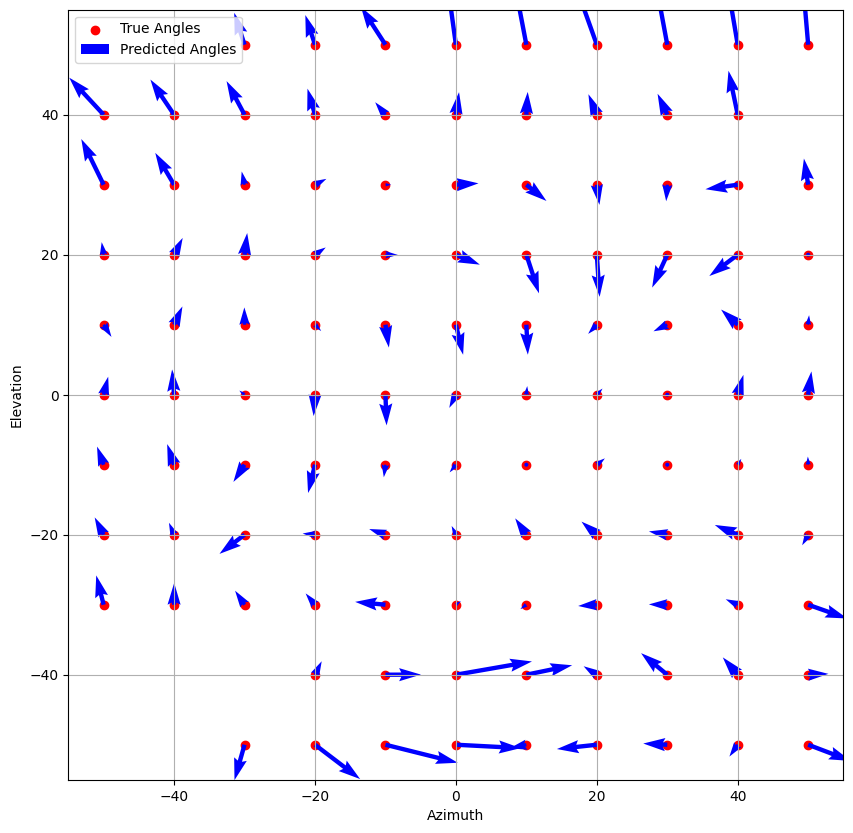

In [30]:
criterion = nn.MSELoss()
experiment_path = '/home/mohammad.hallaq/workarea/AoA-Pruning/experiments'
device = general_device
pruned_model = pruned_model.to(device)
pruned_model.eval()
eval_values = {'azimuth_true': [], 'azimuth_pred': [], 'elevation_true': [], 'elevation_pred': [], 'loss_value': []}

test_loss, num_samples = 0, 0
all_targets, all_outputs = np.zeros([1, 2]), np.zeros([1, 2])
with torch.no_grad():
    with tqdm(test_loader, desc='Testing', unit='batch') as pbar:
        for sample_inputs, targets in pbar:
            sample_inputs = sample_inputs.to(device)
            targets = targets.to(device)
            outputs = pruned_model(sample_inputs)
            loss = criterion(outputs, targets)
            eval_values['azimuth_pred'] = targets
            num_samples += targets.shape[0]
            test_loss += loss.item()/num_samples
            all_targets = np.concatenate((all_targets, targets.cpu()))
            all_outputs = np.concatenate((all_outputs, outputs.cpu()))
            pbar.set_postfix({'Val Loss': test_loss})
    all_outputs = all_outputs[1:]
    all_targets = all_targets[1:]
    test_loss = test_loss / len(test_loader)
    print(f"Test Set Loss = {test_loss}")
    quiver_path = os.path.join(experiment_path, "testing_quiver_plot.png")
    plot_quiver(all_targets, all_outputs, quiver_path)